In [1]:
 from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')


# DATA IMPORT AND VISUALISATION:


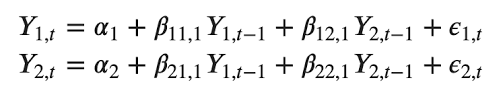

In [39]:
filepath = r"/home/marko/Documents/ElectionLogic/wpd/2024-113.csv"
macro_data = pd.read_csv(filepath)
print(macro_data.shape)  # (123, 8)
macro_data['HDZ'] = macro_data['HDZ'].astype(float)
macro_data.head()

(113, 10)


,HDZ,SDP,KH,MOST,HNS-LD,DPMS,Centar,Fokus,Mozemo!,RF
0,0.379750,0.209974,0.026797,0.097305,0.007581,0.101421,0.0,0.0,0.128688,0.0
1,0.373473,0.186308,0.022124,0.081151,0.013755,0.070964,0.0,0.0,0.099054,0.0
2,0.375634,0.211929,0.005317,0.088044,0.013755,0.092057,0.0,0.0,0.103993,0.0
3,0.388187,0.198450,0.015607,0.073536,0.009742,0.092675,0.0,0.0,0.096893,0.0
4,0.352997,0.212341,0.017150,0.100598,0.009742,0.096585,0.0,0.0,0.106257,0.0


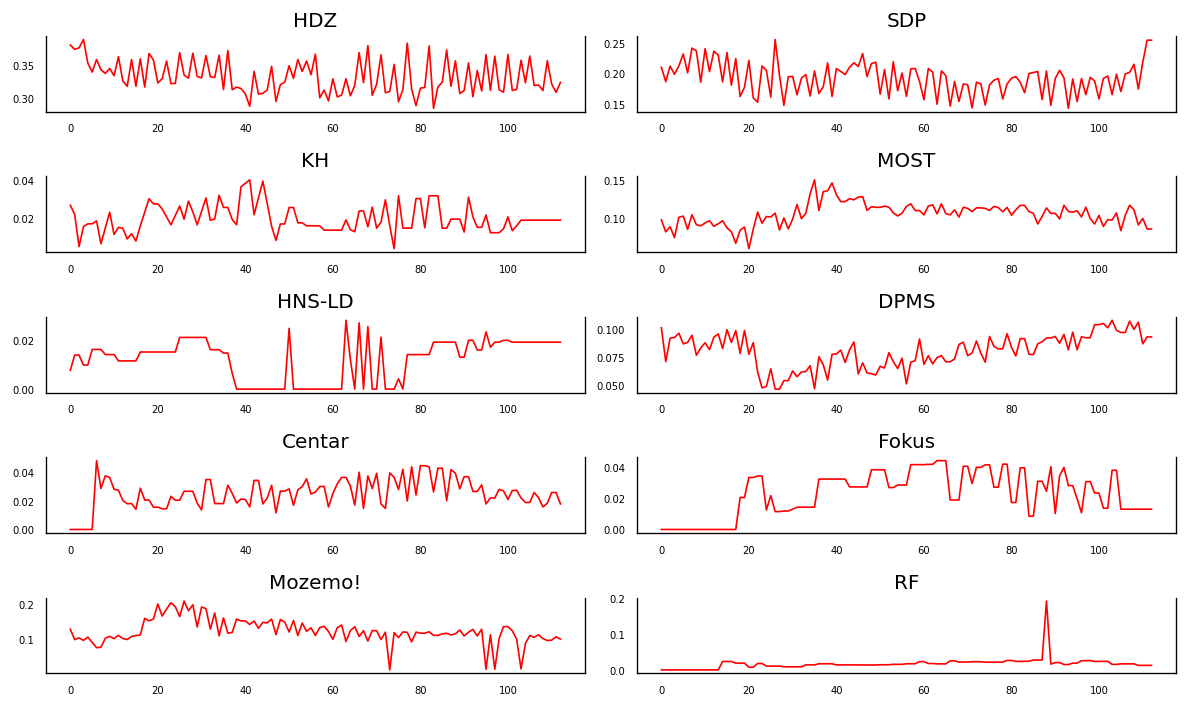

In [4]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# DATA STATIONARITY CHECK:

In [8]:
col_names = macro_data.columns

for i in range (len(col_names)):
    ad_fuller_result = adfuller(macro_data[col_names[i]].diff()[1:])
    
    print(col_names[i])
    print(f'ADF Statistic: {ad_fuller_result[0]}')
    print(f'p-value: {ad_fuller_result[1]}')
    
    print('\n---------------------\n')

HDZ
ADF Statistic: -4.505987089242217
p-value: 0.00019179927478607994

---------------------

SDP
ADF Statistic: -10.860979736747383
p-value: 1.44667907575611e-19

---------------------

KH
ADF Statistic: -6.331301353668742
p-value: 2.9018793192642457e-08

---------------------

MOST
ADF Statistic: -9.36880603034948
p-value: 7.473611376889044e-16

---------------------

HNS-LD
ADF Statistic: -13.720890548030876
p-value: 1.1884839098174477e-25

---------------------

DPMS
ADF Statistic: -5.865964391053057
p-value: 3.32511349130085e-07

---------------------

Centar
ADF Statistic: -6.361841882492799
p-value: 2.463512570712698e-08

---------------------

Fokus
ADF Statistic: -11.57758162123208
p-value: 2.9966335384967707e-21

---------------------

Mozemo!
ADF Statistic: -7.282200185078862
p-value: 1.4902937733394343e-10

---------------------

RF
ADF Statistic: -6.479454498592448
p-value: 1.3060367237269541e-08

---------------------



# DATA CAUSALITY CHECK:

In [9]:
col_names = macro_data.columns

for i in range(len(col_names)):
    for j in range(len(col_names)):
        if i == j: continue
        print(col_names[i] + ' causes ' + col_names[j])
        print('------------------')
        granger_1 = grangercausalitytests(macro_data[[col_names[j], col_names[i]]], 4)
        print('------------------')
        print('------------------')


HDZ causes SDP
------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7384  , p=0.0558  , df_denom=109, df_num=1
ssr based chi2 test:   chi2=3.8412  , p=0.0500  , df=1
likelihood ratio test: chi2=3.7768  , p=0.0520  , df=1
parameter F test:         F=3.7384  , p=0.0558  , df_denom=109, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1446  , p=0.1222  , df_denom=106, df_num=2
ssr based chi2 test:   chi2=4.4916  , p=0.1058  , df=2
likelihood ratio test: chi2=4.4031  , p=0.1106  , df=2
parameter F test:         F=2.1446  , p=0.1222  , df_denom=106, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2404  , p=0.8680  , df_denom=103, df_num=3
ssr based chi2 test:   chi2=0.7703  , p=0.8565  , df=3
likelihood ratio test: chi2=0.7676  , p=0.8572  , df=3
parameter F test:         F=0.2404  , p=0.8680  , df_denom=103, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F te

# SORTING DATA TO TRAINING AND TESTING:

In [10]:
#macro_data = macro_data.iloc[:200, :]
print(macro_data.shape)

(113, 10)


In [11]:
train_df=macro_data[:-12]
test_df=macro_data[-12:]

In [12]:
print(test_df.shape)

(12, 10)


# FINDING APPROPRIATE LAG VARIABLE:

In [13]:
model = VAR(train_df.diff()[1:])

In [26]:
sorted_order=model.select_order(maxlags=8)
print(sorted_order.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -83.54     -83.27*   5.231e-37      -83.43
1      -85.67      -82.65   6.309e-38      -84.45
2      -86.76      -81.01   2.266e-38      -84.44
3      -86.53      -78.03   3.471e-38      -83.10
4      -86.12      -74.88   7.772e-38      -81.58
5      -86.10      -72.12   1.648e-37      -80.46
6      -87.84      -71.12   1.063e-37      -81.09
7      -91.04      -71.57   4.574e-38      -83.18
8     -103.8*      -81.55  1.817e-41*     -94.79*
-------------------------------------------------


# FITTING DATA INTO MODEL:

In [27]:
var_model = VARMAX(train_df, order=(8,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                                           Statespace Model Results                                                           
Dep. Variable:     ['HDZ', 'SDP', 'KH', 'MOST', 'HNS-LD', 'DPMS', 'Centar', 'Fokus', 'Mozemo!', 'RF']   No. Observations:                  101
Model:                                                                                         VAR(8)   Log Likelihood                1926.749
                                                                                          + intercept   AIC                          -2123.498
Date:                                                                                Wed, 03 Apr 2024   BIC                            138.582
Time:                                                                                        15:04:33   HQIC                         -1207.743
Sample:                                                                                             0                                         

# FORECASTING + VISUALISATION:

In [28]:
n_forecast = 12
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)#start="1989-07-01",end='1999-01-01')

predictions=predict.predicted_mean

In [35]:
predictions.columns=['hdz_predicted','sdp_predicted', 'kh_predicted','most_predicted', 'hnsld_predicted','dpms_predicted', 'centar_predicted','fokus_predicted', 'mozemo_predicted','rf_predicted', ]
predictions

,hdz_predicted,sdp_predicted,kh_predicted,most_predicted,hnsld_predicted,dpms_predicted,centar_predicted,fokus_predicted,mozemo_predicted,rf_predicted
101,0.333517,0.190765,0.020358,0.106124,0.011046,0.078132,0.025411,0.024036,0.126180,0.017115
102,0.333519,0.190756,0.020327,0.106114,0.011048,0.078147,0.025412,0.024006,0.126184,0.017112
103,0.333529,0.190761,0.020325,0.106114,0.011045,0.078147,0.025409,0.023998,0.126208,0.017117
104,0.333528,0.190776,0.020311,0.106111,0.011045,0.078122,0.025393,0.023965,0.126219,0.017110
105,0.333527,0.190785,0.020315,0.106110,0.011042,0.078117,0.025391,0.023959,0.126242,0.017129
106,0.333541,0.190780,0.020310,0.106110,0.011043,0.078100,0.025378,0.023909,0.126278,0.017177
107,0.333533,0.190782,0.020310,0.106113,0.011041,0.078093,0.025377,0.023916,0.126266,0.017158
108,0.333530,0.190788,0.020314,0.106115,0.011036,0.078092,0.025381,0.023945,0.126257,0.017136
109,0.333531,0.190790,0.020317,0.106113,0.011035,0.078090,0.025382,0.023960,0.126252,0.017127
110,0.333531,0.190790,0.020317,0.106113,0.011035,0.078090,0.025382,0.023960,0.126252,0.017127


In [36]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

<Axes: >

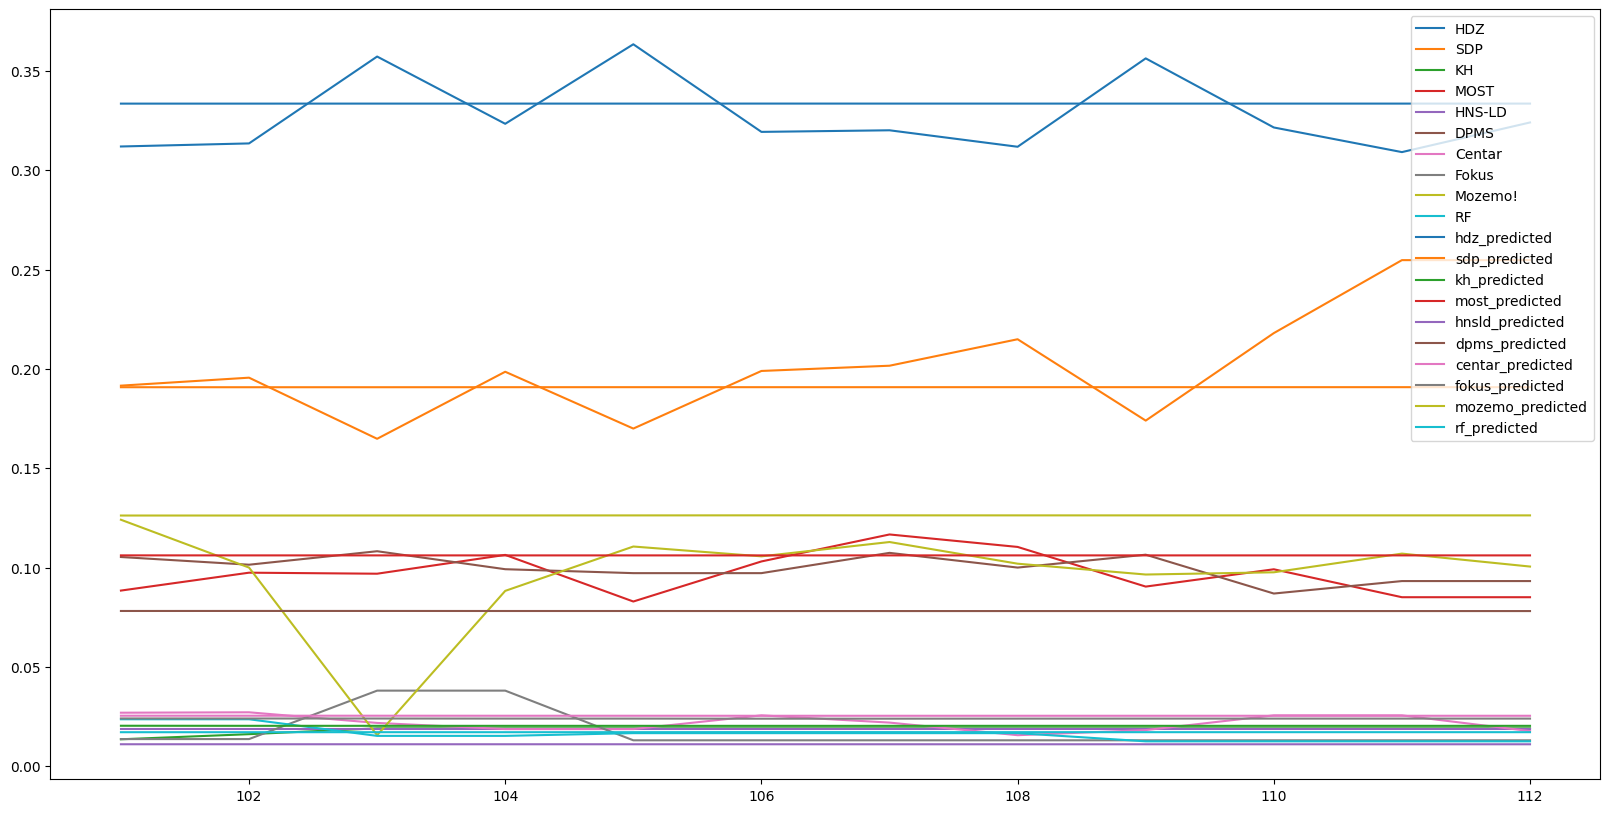

In [37]:
test_vs_pred.plot(figsize=(20,10))

# FORECASTING ERROR CHECK:

In [43]:
from sklearn.metrics import mean_squared_error
import math 
from statistics import mean

rmse_hdz=math.sqrt(mean_squared_error(predictions['hdz_predicted'],test_df['HDZ']))
print('Mean value of HDZ is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['HDZ']),rmse_hdz))

rmse_sdp=math.sqrt(mean_squared_error(predictions['sdp_predicted'],test_df['SDP']))
print('Mean value of SDP is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['SDP']),rmse_sdp))

rmse_kh=math.sqrt(mean_squared_error(predictions['kh_predicted'],test_df['KH']))
print('Mean value of KH is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['KH']),rmse_kh))

rmse_most=math.sqrt(mean_squared_error(predictions['most_predicted'],test_df['MOST']))
print('Mean value of MOST is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['MOST']),rmse_most))

rmse_hnsld=math.sqrt(mean_squared_error(predictions['hnsld_predicted'],test_df['HNS-LD']))
print('Mean value of HNS-LD is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['HNS-LD']),rmse_hnsld))

rmse_dpms=math.sqrt(mean_squared_error(predictions['dpms_predicted'],test_df['DPMS']))
print('Mean value of DPMS is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['DPMS']),rmse_dpms))

rmse_centar=math.sqrt(mean_squared_error(predictions['centar_predicted'],test_df['Centar']))
print('Mean value of Centar is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['Centar']),rmse_centar))

rmse_fokus=math.sqrt(mean_squared_error(predictions['fokus_predicted'],test_df['Fokus']))
print('Mean value of Fokus is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['Fokus']),rmse_fokus))

rmse_mozemo=math.sqrt(mean_squared_error(predictions['mozemo_predicted'],test_df['Mozemo!']))
print('Mean value of Mozemo! is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['Mozemo!']),rmse_mozemo))

rmse_rf=math.sqrt(mean_squared_error(predictions['rf_predicted'],test_df['RF']))
print('Mean value of RF is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['RF']),rmse_rf))

Mean value of HDZ is : 0.32762782647529. Root Mean Squared Error is :0.019637544480078328
Mean value of SDP is : 0.20310915521330933. Root Mean Squared Error is :0.030494463979530415
Mean value of KH is : 0.018355365377940084. Root Mean Squared Error is :0.0025791607503256936
Mean value of MOST is : 0.09680902094800464. Root Mean Squared Error is :0.013945577487809576
Mean value of HNS-LD is : 0.0189509330732739. Root Mean Squared Error is :0.007910378589509257
Mean value of DPMS is : 0.09963051501310405. Root Mean Squared Error is :0.02241537970702454
Mean value of Centar is : 0.02194915756183296. Root Mean Squared Error is :0.005220093225821812
Mean value of Fokus is : 0.017304624869832568. Root Mean Squared Error is :0.011411448175643405
Mean value of Mozemo! is : 0.09670673915113902. Root Mean Squared Error is :0.039316080658629245
Mean value of RF is : 0.016201369719609667. Root Mean Squared Error is :0.0038489758782082007
